<tr>
  <td><img src="media/kit_logo.png" width=200></td>
  <td></td>
  <td><img src="media/curac_logo.png" width=400></td>
  <td></td>
  <td><img src="media/hera_logo.png" width=200></td>
</tr>

Paul Maria Scheikl - Health Robotics and Automation (HERA) - Karlsruhe Institute of Technology (KIT)

# Real World Example: Classifying Pigmented Lesions
To build an example that is more relevant to the medical field, we will now build a complete training pipeline for classifying pigment leasions in the [Skin Cancer MNIST dataset](https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000).

The dataset consists of 10015 images that show cropped images of pigmented lesions and are annotated with a diagnostic case label.


"*Cases include a representative collection of all important diagnostic categories in the realm of pigmented lesions: Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec), basal cell carcinoma (bcc), benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl), dermatofibroma (df), melanoma (mel), melanocytic nevi (nv) and vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc).*" [\[ref\]](https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000)

<table>
  <tr>
    <td><img src="media/ISIC_0025873.jpg" alt="1"></td>
    <td><img src="media/ISIC_0026024.jpg" alt="2"</td>
    <td><img src="media/ISIC_0027359.jpg" alt="3"</td>
    <td><img src="media/ISIC_0033637.jpg" alt="4"</td>
  </tr>
 </table>


## Data preparation
We have already prepared a function that reads the image file paths from a folder, as well as the labels that are stored in the csv file. The function returns a [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) which acts as in iterator, so we can use it to generate mini batches of data for our training loop. The images used for training are further scaled down to half resolution.

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from livelossplot import PlotLosses
from pathlib import Path
from tqdm.notebook import tqdm
from copy import deepcopy
from matplotlib import rcParams
from torchsummary import summary

from utils.data import load_dataset
from utils.data import CaseTypes

image_dir = Path("data") / Path("skin") / Path("images")
metadata_csv = Path("data") / Path("skin") / Path("metadata.csv")

# Network training using the GPU -> cuda or CPU -> cpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Whether to save the trained model as a file
save_model = False
model_save_path = Path("models") / Path("skin_cancer_prediction_model.pkl")

In contrast to our simple sine function example, we will not hold the complete data for training in memory and predict the model outputs of the complete data (called batch gradient descent).
In this case we will use mini batch gradient descent and calculate the gradients on mini batches of size *32* (one input to the model consists of 32 examples).
The gradient with regard to our loss function will be not as accurate, compared to using the complete dataset, but computation will be much faster.

Also note, that we split up the data into three separate datasets, that do not share data points.
In our sine example, we wanted the model to match the data as best as possible, basically memorizing the data.
In this case, however, we do not want the model to memorize the datapoints, otherwise we could not use it on new data. This problem of memorizing data is called [**overfitting**](https://en.wikipedia.org/wiki/Overfitting) and happens when the model has so much capacity, that it begins to interpolate the data as training goes on, rather than learning the underlying distribution of the data.

<figure>
    <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/19/Overfitting.svg/300px-Overfitting.svg.png" alt="Overfitting" style="width: 350px;"/>
    <figcaption><a href="https://en.wikipedia.org/wiki/Overfitting">[ref]</a>
</figure>

We address this problem by reserving a certain amount of data for training, another set of data points for evaluating how well the model generalizes on unseen data to stop the training before overfitting occurs, and finally the rest of the data to test the final performance of the model.

* **Training Dataset**: The sample of data used to fit the model.
* **Validation Dataset**: The sample of data used to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters.
* **Test Dataset**: The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset. [ref](https://machinelearningmastery.com/difference-test-validation-datasets/)


<details>
<summary><b>Question</b>: Why do we need separate evaluation and testing data?</summary>
<p>

Because the evaluation results of the validation dataset will be biased towards our hyperparameter choices, because we used this data to select them.

</p>
</details>
    

## Data Normalization
Another step to prepare our image dataset for the machine learning part is normalizing the data.

*Data normalization is an important step which ensures that each input parameter (pixel, in this case) has a similar data distribution. This makes convergence faster while training the network. Data normalization is done by subtracting the mean from each pixel and then dividing the result by the standard deviation. The distribution of such data would resemble a Gaussian curve centered at zero.* [ref](https://becominghuman.ai/image-data-pre-processing-for-neural-networks-498289068258)

We could calculate the mean and standard deviation on a single image, but this would lead to very different data distributions on a per image basis. Imaging our dataset contains images that are either completely black or completely white. Normalizing each image independently will lead to images that are all the same.
This is why we have to calculate our values for mean and standard deviation of the complete dataset.
For RGB images, it is common to calculate mean and standard deviation for each color channel independently, so we will get three mean values and three standard deviations.

First, lets look at some of the images in the dataset.

[HERA INFO]: Created skin cancer dataset from image paths and labels for 10015 data points.
[HERA INFO]: Target key is dx for targets of type <enum 'CaseTypes'>.
[HERA INFO]: Created a single DataLoader from DataSet with batch size 100.
[HERA INFO]: The image shape is (225, 300)
[HERA INFO]: Datapoints will not be shuffled after a full pass.


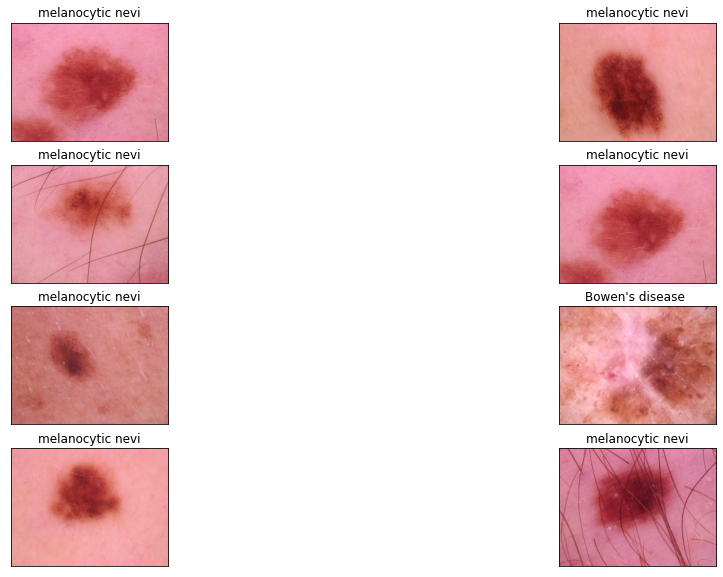

In [9]:
# create a data loader
image_shape = (225, 300)
data_loader = load_dataset(
    image_dir,
    metadata_csv,
    batch_size=100,
    resize_image_shape=image_shape,
    do_shuffle=False,
    single_loader=True,
    num_workers=8,
)

indices = np.random.choice(list(range(len(data_loader.dataset))), 8)
images = [np.moveaxis(deepcopy(data_loader.dataset[i][0].numpy()), 0, -1) for i in indices]
labels = [data_loader.dataset[i][1] for i in indices]
titles = []
for label in labels:
    for case in CaseTypes:
        if case.id == label:
            titles.append(case.description)
        else:
            pass

%matplotlib inline

# figure size in inches optional
rcParams['figure.figsize'] = 18 ,10

# display images
fig, axes = plt.subplots(4,2)
axes = axes.flatten()
for i in range(8):
    axes[i].imshow(images[i]);
    axes[i].set_title(titles[i], wrap=True)
    axes[i].set_xticks([])
    axes[i].set_yticks([])

As you can see, there is little contrast in the images and they are all in all mostly red.

In [10]:
# placeholders for temporary values we need to calculate mead and standard deviation
pixel_sum = torch.tensor([0.0, 0.0, 0.0])
pixel_sum_squared = torch.tensor([0.0, 0.0, 0.0])

# loop through the image batches in the data loader
for image_batch, _ in tqdm(data_loader, desc="Calculating..."):
    pixel_sum += image_batch.sum(axis=[0, 2, 3])
    pixel_sum_squared += (image_batch ** 2).sum(axis=[0, 2, 3])

# number of pixel in the dataset
num_images = len(data_loader.dataset)
count = num_images * image_shape[0] * image_shape[1]

# mean and std
mean = pixel_sum / count
var = (pixel_sum_squared / count) - (mean ** 2)
std = torch.sqrt(var)

print(f"Mean: {mean.numpy()}\nStandard Deviation: {std.numpy()}")

Calculating...:   0%|          | 0/101 [00:00<?, ?it/s]

Mean: [0.7635213  0.546128   0.57053053]
Standard Deviation: [0.1408046  0.15247564 0.1698052 ]


We can see, that the images are indeed leaning towards the red colors (first value of the mean), and the standard deviations are very small (little contrast) compared to the normal Gaussian distribution with a standard deviation of 1 that we are aiming for.

We can now load the dataset with the normalization parameters into the three different splits for training, validating, and testing.

In [11]:
train_data_loader, val_data_loader, test_data_loader = load_dataset(
    image_dir,
    metadata_csv,
    batch_size=32,
    resize_image_shape=image_shape,
    normalize_images=True,
    normalize_mean=mean.numpy(),
    normalize_std=std.numpy(),
    do_shuffle=True,
    split_ratios=(0.7, 0.15, 0.15),
    single_loader=False,
    num_workers=8
)

[HERA INFO]: Created skin cancer dataset from image paths and labels for 10015 data points.
[HERA INFO]: Target key is dx for targets of type <enum 'CaseTypes'>.
[HERA INFO]: Images will be normalized with:
 mean: [0.7635213  0.546128   0.57053053] and
 std: [0.1408046  0.15247564 0.1698052 ].
[HERA INFO]: Created three DataLoaders from DataSet with batch size 32.
[HERA INFO]: There are 7010, 1502, and 1503 data points for training, validating, and testing, respectively.
[HERA INFO]: The image shape is (225, 300)
[HERA INFO]: Datapoints will be shuffled after a full pass.


## Convolutional Neural Network
As we have seen in the introduction, MLPs are not suited to work on images.
We will use a CNN as the model to classify the images.
For this, we will create a new class called CNN, based on a pytorch nn.Module, that consists of 4 convolutional layers, each with ReLU activation functions, a max pooling layer to reduce the feature size without introducing additional learnable parameters, and finally two additional fully connected layers.
The output of the last layer will be passed to a LogSoftmax function that generates log-likelihoods for each of the seven possible cases labels in the dataset.
$$
\text{LogSoftmax}(x_{i}) = \log\left(\frac{\exp(x_i) }{ \sum_j \exp(x_j)} \right)
$$

In [24]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, 2)
        self.conv3 = nn.Conv2d(32, 64, 3, 2)
        self.conv4 = nn.Conv2d(64, 128, 3, 2)
        self.fc1 = nn.Linear(6144, 128)
        self.fc2 = nn.Linear(128, 7)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

cnn_model = CNN().to(device)
summary(cnn_model, (3, 225, 300))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 149]             448
            Conv2d-2           [-1, 32, 55, 74]           4,640
            Conv2d-3           [-1, 64, 27, 36]          18,496
            Conv2d-4          [-1, 128, 13, 17]          73,856
            Linear-5                  [-1, 128]         786,560
            Linear-6                    [-1, 7]             903
Total params: 884,903
Trainable params: 884,903
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.77
Forward/backward pass size (MB): 3.72
Params size (MB): 3.38
Estimated Total Size (MB): 7.87
----------------------------------------------------------------


<figure>
    <img src="media/cnn.png" alt="CNN" style="width: 600px;"/>
</figure> 

As you can see, the majority of trainable parameters is part of the fully connected layers.
We could prevent this by introducing more convolutional layers or pooling layers to reduce the dimensionality.
For now, this will do.

## Hyperparameters for the Training
The training loop for this example will also be a bit more complex that the initial sine example.

### Loss Function
The output of our network is a list with seven elements.
The value of element n represents the log-likelihood of the image belonging to class n.
So if the image belongs to class 3 (beginning from 0), we want the neural network's output list to have its maximum value at index 3.
The loss function that quantifies the distance between the output of the neural network and the ground truth list of log-likelihoods in a classification problem with multiple classes is the negative log-likelihood loss (NLLLOSS).

Negative log-likelihood loss is the same as cross entropy loss (aka logistic loss or multinomial logistic loss), with the difference, that our model already outputs the log probalities for each class.

$$
\text{CrossEntropyLoss}(x, label) = -\log\left(\frac{\exp(x[label])}{\sum_j \exp(x[j])}\right)
$$

So the negative log-likelihood loss reduces to
$$
\text{NLLLOSS}(prediction, label) = -prediction[label]
$$
where prediction is the list of log-likelihoods, produced by the neural network.


In [13]:
loss_function = nn.NLLLoss().to(device)

In [14]:
with torch.no_grad():
    images, labels = next(iter(data_loader))
    prediction = cnn_model(images.to(device))
    print("Log-likelihoods for one image: ", prediction[0].cpu())
    print("Ground truth label: ", labels[0])
    print("NLLLoss: ", loss_function(prediction[0].unsqueeze(0), labels[0].unsqueeze(0).to(device)).cpu())

Log-likelihoods for one image:  tensor([-1.9646, -1.8996, -1.9267, -1.9468, -1.9996, -1.9540, -1.9331])
Ground truth label:  tensor(4)
NLLLoss:  tensor(1.9996)


### Optimizer
At this point, we have a neural network and a loss function.
The next step is defining an optimizer that adapts the neural network parameters to minimize the loss over our training data.

In the last notebook, we used the SGD optimizer. In this notebook, we will use a more sofisticated optimizer: Adaptive Moment Estimation (Adam).
In contrast to SGD, Adam *remembers* previous gradients for each parameter, and adapts the parameter specific learning rates accordingly. 

The update Rule from SGD
$$
\begin{align} 
\begin{split} 
\theta_{t+1} = \theta_{t}-\gamma\nabla L(\theta_{t})
 = \theta_{t}-\gamma g_{t}
\end{split} 
\end{align}
$$

changes to Adam's update rule
$$
\begin{align} 
\begin{split}
\theta_{t+1} = \theta_{t} - \dfrac{\gamma}{\sqrt{\hat{v}_t} + \epsilon} \hat{m}_t
\end{split} 
\end{align}
$$

$\hat{m}_t$ and $\hat{v}_t$ are bias-corrected first and second moment estimates that scale the learning rate.

The bias-corrected first and second moment are estimated through

$$
\begin{align} 
\begin{split} 
\hat{m}_t &= \dfrac{m_t}{1 - \beta^t_1} \\ 
\hat{v}_t &= \dfrac{v_t}{1 - \beta^t_2} \end{split} 
\end{align}
$$

with

$$
\begin{align} 
\begin{split} 
m_t &= \beta_1 m_{t-1} + (1 - \beta_1) g_t \\ 
v_t &= \beta_2 v_{t-1} + (1 - \beta_2) g_t^2 
\end{split} 
\end{align}
$$

$\beta_1$, $\beta_2$, and $\epsilon$ are hyperparameters of the optimizer.


This leads to a dynamic behavior of the optimizer that resembles a heavy ball, rolling down a curved slope under friction.

<figure>
    <img src="https://miro.medium.com/max/600/1*STiRp7PW5yIrvYZupZA6nw.gif" alt="adam" style="width: 600px;"/>
    <figcaption><a href="https://towardsdatascience.com/complete-guide-to-adam-optimization-1e5f29532c3d">[ref]</a>
</figure>



In [16]:
# Learning rate for the optimizer
learning_rate = 0.00001

optimizer = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)
# test what happens when you use a different optimizer such as 
# optimizer = torch.optim.SGD(cnn_model.parameters(), lr=learning_rate*100, momentum=0.9)

### Early Stopping
Instead of training a fixed amount of epoch, we will use a technique called early stopping, to interrrupt the training at the right time.
We set the maximum number of epochs to a high value and also specify an early stopping patience.
The early stopping patients will interrupt the training, once the validation loss has not decreased in the last n epochs. This way, we can pinpoint the epoch where our model is likely to have learned the most, without overfitting too much.

<figure>
    <img src="media/early_stopping.png" alt="Topology" style="width: 500px;"/>
    <figcaption><a href="https://www.kaggle.com/ryanholbrook/overfitting-and-underfitting">[ref]</a>
</figure>
    

In [17]:
# How many complete dataset passes to train
epochs = 200

# How many epochs of not decreasing validation loss to wait before stopping the training
early_stop_patience = 20

### Learning Rate Scheduler
If the learning rate of our scheduler is too large, we are likely to *miss* the optimum in parameter space by taking steps that are too big. If the learning rate is too small, however, training may take too long. 

<figure>
    <img src="    https://www.deeplearningwizard.com/deep_learning/boosting_models_pytorch/images/lr1.png" alt="Topology" style="width: 900px;"/>
    <figcaption><a href="https://www.deeplearningwizard.com/deep_learning/boosting_models_pytorch/lr_scheduling/">[ref]</a>
</figure>
    
A learning rate scheduler will take an initial learning rate and adapt the learning rate during training, based on a performance metric. In this example, we will start with a *high* learning rate, and use a scheduler, that decreases the learning rate, when the training loss plateaus. The scheduler uses a patience parameter to decide whether it is time to decrease the learning rate, similar to early stopping. 

    
<details>
<summary><b>Question</b>: But isn't Adam taking care of the learning rate?</summary>
<p>

    Correct! In practice, though, reducing the fixed part of the learning rate sometimes helps to descend faster into a minimum.

</p>
</details>

In [18]:
# Parameters for the learning rate scheduler:

# How many epochs of not decreasing training loss to wait, before decreasing the learning rate
lr_scheduler_patience = 8

# Factor by which the learning rate will be reduced. new_lr : lr * factor.
lr_factor = 0.1

lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    verbose=True,
    factor=lr_factor,
    patience=lr_scheduler_patience
)

### Initial Performance
Let's test the initial performance of our model without any training.

In [19]:
import ipywidgets as widgets
from ipywidgets import Layout
from utils.training import evaluate, get_lr

start_train_bar_widget = widgets.IntProgress(
    value=0,
    min=0,
    max=len(train_data_loader),
    description='Calculating initial training loss:',
    bar_style='info', # 'success', 'info', 'warning', 'danger' or ''
    style={'bar_color': 'green', 'description_width': 'initial'},
    orientation='horizontal'
)

start_val_bar_widget = widgets.IntProgress(
    value=0,
    min=0,
    max=len(val_data_loader),
    description='Calculating initial validation loss and accuracy:',
    bar_style='info', # 'success', 'info', 'warning', 'danger' or ''
    style={'bar_color': 'green', 'description_width': 'initial'},
    orientation='horizontal'
)
initial_hbox = widgets.HBox(children=(start_train_bar_widget,start_val_bar_widget))

display(initial_hbox)
initial_train_loss, _ = evaluate(
        cnn_model=cnn_model,
        device=device,
        iterator=train_data_loader,
        criterion=loss_function,
        progress_bar=start_train_bar_widget,
    )

initial_val_loss, initial_val_acc = evaluate(
        cnn_model=cnn_model,
        device=device,
        iterator=val_data_loader,
        criterion=loss_function,
        progress_bar=start_val_bar_widget,
    )

print("Initial training loss: ", initial_train_loss)
print("Initial validation loss: ", initial_val_loss)
print("Initial accuracy: ", initial_val_acc)

Initial training loss:  0.06110729373652827
Initial validation loss:  0.061130413111854104
Initial accuracy:  0.05452127659574468


In [20]:
style = {'description_width': 'initial'}

epoch_widget = widgets.Text(
    value=f'{0}/{epochs}',
    description='Epoch:',
    style=style,
    disabled=True
)

early_stopping_widget = widgets.Text(
    value=f'{0}/{early_stop_patience}',
    description='Early Stopping Patience:',
    style=style,
    disabled=True,
)

learning_rate_widget = widgets.FloatText(
    value=learning_rate,
    description='Learning Rate:',
    style=style,
    disabled=True,
)

learning_rate_patience_widget = widgets.Text(
    value=f'{0}/{lr_scheduler_patience}',
    description='Learning Rate Patience:',
    style=style,
    disabled=True,
)

train_loss_widget = widgets.FloatText(
    value=initial_train_loss,
    description='Training Loss:',
    style=style,
    disabled=True,
)
val_loss_widget = widgets.FloatText(
    value=initial_val_loss,
    description='Validation Loss:',
    style=style,
    disabled=True
)
val_acc_widget = widgets.FloatText(
    value=initial_val_acc,
    description='Validation Accuracy:',
    style=style,
    disabled=True
)

train_bar_widget = widgets.IntProgress(
    value=0,
    min=0,
    max=len(train_data_loader),
    description='Training one epoch:',
    bar_style='info', # 'success', 'info', 'warning', 'danger' or ''
    style={'bar_color': 'green', 'description_width': 'initial'},
    orientation='horizontal'
)

val_bar_widget = widgets.IntProgress(
    value=0,
    min=0,
    max=len(val_data_loader),
    description='Validation:',
    bar_style='info', # 'success', 'info', 'warning', 'danger' or ''
    style={'bar_color': 'green', 'description_width': 'initial'},
    orientation='horizontal'
)

progress_hbox = widgets.HBox(children=(epoch_widget,early_stopping_widget))
learning_rate_hbox = widgets.HBox(children=(learning_rate_widget, learning_rate_patience_widget))
loss_hbox = widgets.HBox(children=(train_loss_widget, val_loss_widget,val_acc_widget))
bar_hbox = widgets.HBox(children=(train_bar_widget, val_bar_widget))


vbox = widgets.VBox(children=(progress_hbox, learning_rate_hbox, loss_hbox, bar_hbox))

## Actual Training of the CNN
The training loop in this notebook is pretty much the same as in the initial notebook.

### Train
1. Compute the outputs of the neural network for each data point in the training set.
2. Compute the loss between predicted outputs and ground truth.
3. Clean up the buffer variables inside the optimizer.
4. Compute the gradients from the loss function.
5. Perform one step in the optimizer.

### Validation
1. Compute the outputs of the neural network for each data point in the validation set.
2. Compute the loss between predicted outputs and ground truth.

### Rest
1. Adapt the learning rate with the learning rate scheduler, if necessary.
2. Stop the training, if the early stopping rule applies.

In [ ]:
# def train(cnn_model, device, iterator, optimizer, criterion, progress_bar):

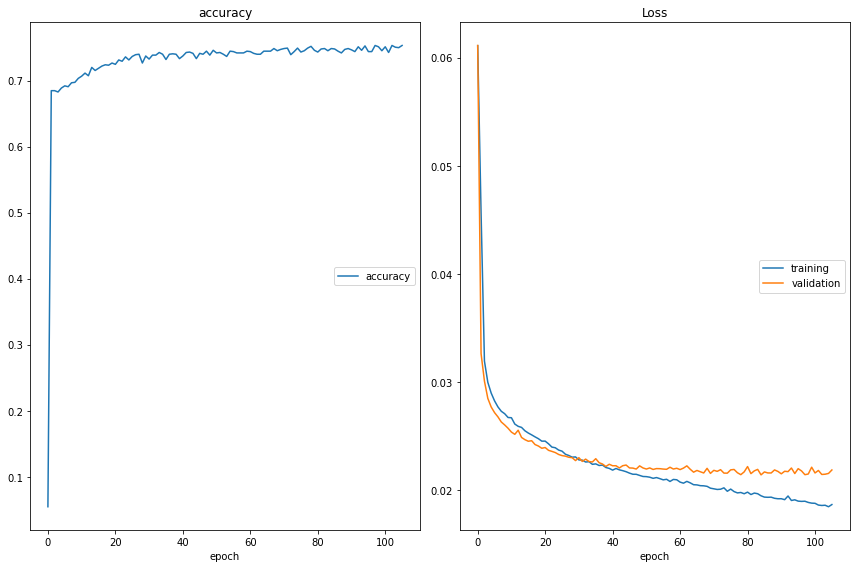

accuracy
	accuracy         	 (min:    0.055, max:    0.753, cur:    0.753)
Loss
	training         	 (min:    0.018, max:    0.061, cur:    0.019)
	validation       	 (min:    0.021, max:    0.061, cur:    0.022)
Early stopping


In [22]:
from utils.training import train

# Initialization of the train loss and the validation loss which allow to memorize the best loss obtained.
# best_valid_loss allows the early stopping function to work.
best_train_loss = float('Inf')
best_val_loss = float('Inf')

# Initialization of the counter for early stopping.
early_stopping = 0

liveloss = PlotLosses()
logs = {}
logs['loss'] = initial_train_loss
logs['val_loss'] = initial_val_loss
logs['accuracy'] = initial_val_acc
liveloss.update(logs)
liveloss.send()

for epoch in range(epochs):
        
    train_loss = train(
        cnn_model=cnn_model,
        device=device,
        iterator=train_data_loader,
        optimizer=optimizer,
        criterion=loss_function,
        progress_bar=train_bar_widget,
    )
    
    val_loss, val_acc = evaluate(
        cnn_model=cnn_model,
        device=device,
        iterator=val_data_loader,
        criterion=loss_function,
        progress_bar=val_bar_widget,
    )
    
    # Pass the validation loss to the learning rate scheduler to determine,
    # whether the learning rate should be reduced
    lr_scheduler.step(val_loss)
    
    logs['loss'] = train_loss
    logs['val_loss'] = val_loss
    logs['accuracy'] = val_acc

    liveloss.update(logs)
    liveloss.send()
    
    epoch_widget.value = f"{epoch+1}/{epochs}"
    train_loss_widget.value = train_loss
    val_loss_widget.value = val_loss
    val_acc_widget.value = val_acc

    # Backup of the best train loss achieved
    if train_loss < best_train_loss:
        best_train_loss = train_loss

    # Backup of the best validation loss achieved and save the model if the valid_loss has
    # decreased (valid_loss < best_valid_loss). If not decreased, +1 to early stopping counter.
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        if save_model:
            torch.save(cnn_model, model_save_path)
        early_stopping = 0
        best_model = deepcopy(cnn_model)
    else:
        early_stopping += 1
        
    early_stopping_widget.value = f"{early_stopping}/{early_stop_patience}"
    learning_rate_patience_widget.value = f"{lr_scheduler.num_bad_epochs}/{lr_scheduler_patience}"

    # Lr scheduler check if training loss has decreased and if
    # it hasn't after LR_scheduler_patience of epoch, lr = lr*lr_factor
    lr_scheduler.step(train_loss)
    
    learning_rate_widget.value = get_lr(optimizer)

    # Early stopping :
    if early_stopping > early_stop_patience:
        print("Early stopping")
        break


In [21]:
display(vbox)

<details>
<summary><b>Question</b>: Why is the validation loss lower than the training loss?</summary>
<p>

    Because the training loss is measured <strong>during</strong> each epoch while validation loss is measured <b>after</b> each epoch. So during validation, the model will already have <i> new </i> (updated) parameter values.

</p>
</details>
<details>
<summary><b>Question</b>: What can we do?</summary>
<p>

    Switch the order of validation and training.
    But remember, that it does not really matter.
    It is often easier to think "what is the validation loss <i>after</i> my nth training epoch?".

</p>
</details>
<details>
<summary><b>Question</b>: How can it be, that the accuracy does not change, even though the loss decreases?</summary>
<p>

    Ignoring the log function (only taking the Softmax), the output of the model will be a list of probabilities (values between 0 and 1, that sum to 1).
    The accuracy is determined, by comparing the ground truth label {0..6} with the predicted label by taking the argmax of this list (index of the maximum value in the list).
    The loss, on the other hand, will be the distance between each value of the list and the ground truth value.
    
    For a classification task with two classes:
    With a ground truth label of 1, so a value list of [0.0, 1.0], a change in predicted probabilities from [0.49, 0.51] to [0.1, 0.9] drastically decreases the loss, it will not decrease the predicted class.

</p>
</details>

## Testing the Final Model Performance
To get the final model performance, we need to calculate the loss and accuracy on the test data set.

In [23]:
test_bar_widget = widgets.IntProgress(
    value=0,
    min=0,
    max=len(test_data_loader),
    description='Testing:',
    bar_style='info', # 'success', 'info', 'warning', 'danger' or ''
    style={'bar_color': 'green', 'description_width': 'initial'},
    orientation='horizontal'
)
display(test_bar_widget)

test_loss, test_acc = evaluate(
    cnn_model=best_model,
    device=device,
    iterator=test_data_loader,
    criterion=loss_function,
    progress_bar=test_bar_widget,
)

print("Final testing loss: ", test_loss)
print("Final testing accuracy: ", test_acc)

IntProgress(value=0, bar_style='info', description='Testing:', max=47, style=ProgressStyle(bar_color='green', …

Final testing loss:  0.021463156618336414
Final testing accuracy:  0.7420212765957447


## What's next?
* Instead of importing the training function (`from utils.training import train`), try to implement it yourself.
* Change the CNN model and see how the training results change. You can find a list of possible additional building blocks [here](https://pytorch.org/docs/stable/nn.html#convolution-layers).
* Also try to change the other hyper parameters to maximize the validation accuracy.
* Try to convert the CNN into a fully convolutional architecture, by following the [conv layer formulas](https://cs231n.github.io/convolutional-networks/#conv)

    <ul>
      <li>Volume of size \(W_1 \times H_1 \times D_1\)</li>
      <li>Requires four hyperparameters:
        <ul>
          <li>Number of filters \(K\),</li>
          <li>their spatial extent \(F\),</li>
          <li>the stride \(S\),</li>
          <li>the amount of zero padding \(P\).</li>
        </ul>
      </li>
      <li>Produces a volume of size \(W_2 \times H_2 \times D_2\) where:
        <ul>
          <li>\(W_2 = (W_1 - F + 2P)/S + 1\)</li>
          <li>\(H_2 = (H_1 - F + 2P)/S + 1\) (i.e. width and height are computed equally by symmetry)</li>
          <li>\(D_2 = K\)</li>
        </ul>
      </li>
    </ul>

    and the [pytorch documentation](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d). 